# 1. Build Data Pipeline

In [35]:
!pip install tensorflow tensorflow-gpu matplotlib

  Using cached Pillow-9.2.0-cp39-cp39-win_amd64.whl (3.3 MB)
  Using cached fonttools-4.34.4-py3-none-any.whl (944 kB)
  Using cached kiwisolver-1.4.4-cp39-cp39-win_amd64.whl (55 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)


You should consider upgrading via the 'D:\YouTube\ForzaML\forza\Scripts\python.exe -m pip install --upgrade pip' command.


In [1]:
# Bring in some dependencies
import os 
import tensorflow as tf
import matplotlib.pyplot as plt 

## 1.1 Image Data Pipeline

In [2]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    #img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    #img = img / 255.0
    
    # Return image
    return img

In [3]:
# data
images = tf.data.Dataset.list_files(os.path.join('data', '*.jpg'), shuffle=False)
images = images.map(preprocess)

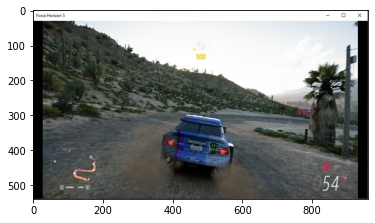

In [4]:
plt.imshow(preprocess('data\\252f0816-1c6c-11ed-a956-5cf3709bbcc6.jpg').numpy())

In [5]:
images.as_numpy_iterator().next().shape

(540, 960, 3)

## 1.2 Key Press Pipeline

In [6]:
#dataset = tf.data.Dataset.list_files(os.path.join('data','*.txt'))
#dataset = dataset.map(lambda x: tf.py_function(parse, [x], (tf.string)))

In [7]:
def preprocess_keypress(filepath):
    keypress = tf.io.read_file(filepath)
    # return keypress
    # return keypress [W,A,S,D,Space] 
    if keypress == "'a'\r\n": 
        return [0,1,0,0,0]
    if keypress == "'w'\r\n": 
        return [1,0,0,0,0]
    if keypress == "'s'\r\n": 
        return [0,0,1,0,0]
    if keypress == "'d'\r\n": 
        return [0,0,0,1,0]
    if keypress == "'Key.space'\r\n":
        return [0,0,0,0,1]
    else: 
        return [0,0,0,0,0]

In [8]:
def wrap_array(x1,x2,x3,x4,x5): 
    return tf.expand_dims([x1,x2,x3,x4,x5], axis=0)

In [41]:
keypress = tf.data.Dataset.list_files(os.path.join('data', '*.txt'), shuffle=False)
keypress = keypress.map(lambda x: tf.py_function(preprocess_keypress, [x], 
                    ([tf.int16,tf.int16,tf.int16,tf.int16,tf.int16])))
keypress = keypress.map(wrap_array)

In [42]:
for x in keypress.as_numpy_iterator(): 
    print(x)

[[0 1 0 0 0]]
[[0 0 0 1 0]]
[[1 0 0 0 0]]
[[0 1 0 0 0]]
[[0 0 0 1 0]]
[[0 1 0 0 0]]
[[0 0 0 1 0]]
[[0 1 0 0 0]]
[[0 0 0 1 0]]
[[0 0 0 1 0]]
[[0 0 0 1 0]]
[[1 0 0 0 0]]
[[0 0 0 1 0]]
[[0 1 0 0 0]]
[[0 0 1 0 0]]
[[0 0 0 1 0]]
[[0 0 0 1 0]]
[[0 0 0 0 0]]
[[0 0 0 1 0]]
[[0 0 0 1 0]]
[[0 0 0 1 0]]
[[0 0 0 1 0]]
[[0 0 0 1 0]]
[[0 0 1 0 0]]
[[0 0 0 1 0]]
[[0 0 1 0 0]]
[[0 0 0 1 0]]
[[0 0 0 1 0]]
[[0 1 0 0 0]]
[[0 1 0 0 0]]
[[0 1 0 0 0]]
[[0 0 0 0 0]]
[[0 0 0 0 0]]


## 1.3 Combine Pipelines

In [69]:
dataset = tf.data.Dataset.zip((images, keypress))

In [44]:
X, y = dataset.as_numpy_iterator().next()

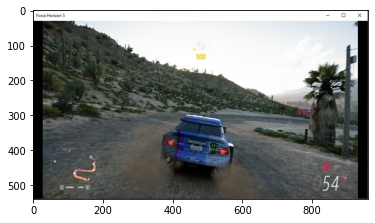

In [45]:
plt.imshow(X)

In [46]:
len(dataset)

33

In [70]:
dataset = dataset.cache()
dataset = dataset.shuffle(40)
dataset = dataset.batch(8)
dataset = dataset.prefetch(4)
dataset = dataset.map(unpack_y)

In [71]:
def unpack_y(x,y): 
    return x, tf.squeeze(y)

In [72]:
X, y = dataset.as_numpy_iterator().next()

In [73]:
len(X)

8

In [74]:
len(y)

8

In [75]:
y

array([[0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0]], dtype=int16)

In [20]:
# MCShBP
# data.map
# data.cache
# data.shuffle
# data.batch
# data.prefetch
# data.zip

# 2. Do Deep Learning Model

In [76]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input

In [77]:
model = Sequential()
model.add(Conv2D(64, 5, strides=(3,3), activation='relu', input_shape=(540, 960, 3)))
model.add(Conv2D(128, 4, strides=(3,3), activation='relu')) 
model.add(Flatten()) 
model.add(Dense(5, activation='softmax'))

In [78]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 179, 319, 64)      4864      
                                                                 
 conv2d_7 (Conv2D)           (None, 59, 106, 128)      131200    
                                                                 
 flatten_3 (Flatten)         (None, 800512)            0         
                                                                 
 dense_3 (Dense)             (None, 5)                 4002565   
                                                                 
Total params: 4,138,629
Trainable params: 4,138,629
Non-trainable params: 0
_________________________________________________________________


In [83]:
model.compile('adam', tf.losses.CategoricalCrossentropy())

In [84]:
model.fit(X, y, epochs=100)

Epoch 1/100
1/1 [==============================] - 0s 327ms/step - loss: 403.4926
Epoch 2/100
1/1 [==============================] - 0s 26ms/step - loss: 935.4561
Epoch 3/100
1/1 [==============================] - 0s 26ms/step - loss: 298.7102
Epoch 4/100
1/1 [==============================] - 0s 25ms/step - loss: 199.1269
Epoch 5/100
1/1 [==============================] - 0s 23ms/step - loss: 26.0033
Epoch 6/100
1/1 [==============================] - 0s 22ms/step - loss: 9.2078
Epoch 7/100
1/1 [==============================] - 0s 22ms/step - loss: 90.8362
Epoch 8/100
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00
Epoch 9/100
1/1 [==============================] - 0s 23ms/step - loss: 6.0648e-04
Epoch 10/100
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00
Epoch 11/100
1/1 [==============================] - 0s 23ms/step - loss: 88.1539
Epoch 12/100
1/1 [==============================] - 0s 22ms/step - loss: 225.1070
Epoch 13/100
1/1 [=====

In [85]:
len(dataset)

5